# 1. Loading and preparing data

**Data sources**

Training data is constructed from two data sources: energy and weather data.

***Energy data source***

Yearly reports of an energy provider from Berlin (Berlin Stromnetz) which are available as Open Data.
Yearly csv-reports are available for years 2011-2015 as well as 2018. They provide information on total energy consumption of small private and industrial clients measured in kW in 15-minute intervals.

***Weather data source***

To gather temperature data associated with the energy consumption data points, I use [Meteostat API](https://github.com/meteostat/meteostat-python) for open weather and climate data.

**Dataset preparation**

Dataset preparation consists of
- loading each yearly historical data csv and formatting it correctly
- adding temperature features to each timestep
- connecting the full dataset

**Time-series dataset split into train, validation and test sets**

As data is used in time series forecasting models, train-test-validation split is not randomized. Instead, slices are made in a way that the time series structure is preserved.


In [1]:
import pandas as pd
import datetime
import os
from meteostat import Point, Hourly
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import IPython
import IPython.display

In [3]:
def read_energy_csv(path):
    """Reading yearly consumption csv, naming columns and formatting the data"""
    df = pd.read_csv(path, skiprows=8, sep=";")
    df.columns = ["Datum", "Zeit", "kW"]

    if df["kW"].dtype == "int64":
        df["kW"] = df["kW"].astype(float)
    elif df["kW"].dtype == "object":
        df["kW"] = df["kW"].str.replace('\.', '', regex=True)
        df["kW"] = df["kW"].str.replace(',', '.', regex=True).astype(float)

    return df

def add_time_features(df):
    """Computing  time features in correct format
    'Date' is datetime format for ordering time series.
    'Daytime' is a float version of daytime used as an input feature in forecasting,
        i.e. 00:30 is represented by 0.3.
    """
    time_df = df.copy()

    time_df["Date"] = time_df["Datum"] + " " + time_df["Zeit"].str.slice(0,5)
    time_df["Date"] = pd.to_datetime(time_df["Date"], format='%d.%m.%Y %H:%M')

    time_df['Daytime'] = time_df['Date'].dt.time.astype(str).str.slice(0,5).str.replace(":",".").astype(float)
    time_df['Hour'] = time_df["Date"].dt.round("H")
    
    time_df = time_df.drop(["Datum","Zeit"], axis=1)

    return time_df

def add_temperature_features(time_df, geopoint):
    """Connect to the Meteostat API, get hourly temperature and add it to each timestep"""
    temperature_df = time_df.copy()

    start = temperature_df["Hour"].iloc[0].to_pydatetime()
    end = temperature_df["Hour"].iloc[-1].to_pydatetime()

    hourly = Hourly(geopoint, start, end)
    hourly = hourly.fetch()
    hourly = hourly.reset_index()
    hourly = hourly[["time", "temp"]]
    hourly.columns = ["Hour","Temperature"]

    temperature_df = temperature_df.merge(hourly, on='Hour', how='left')

    return temperature_df

def get_yearly_df(path, geopoint):
    """Wrapper function to process one yearly consumption csv"""
    df = read_energy_csv(path)
    time_df = add_time_features(df)
    temperature_df = add_temperature_features(time_df, geopoint)

    return temperature_df

def load_dataset(files, geopoint):
    """Load all historical data, sort it as time series and convert kW to mW"""
    dataset = pd.DataFrame()
    for file in files:
        year_df = get_yearly_df(file, geopoint)
        dataset = pd.concat([dataset,year_df])

    dataset = dataset.sort_values("Date")
    dataset["mW"] = dataset["kW"]/1000

    dataset = dataset[["Date", "mW", "Temperature", "Daytime"]]
    
    return dataset

def df_split(df):
    """Train-validation-test on time-series data (non-random slicing)"""
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    return column_indices, train_df, val_df, test_df

In [9]:
files = os.listdir("data")
files = ["data/"+file for file in files]

munich = Point(48.1351, 11.5820, 519)
df = load_dataset(files, munich)

Saving historical data for later use by simulator. Only using data points before 2016 because of the subsequent gap of few years in the data

In [5]:
early = (df['Date'] < '2018-01-01')
historical = df.loc[early]
historical["ts"] = pd.to_datetime(historical["Date"], unit="ns").astype(np.int64) // 10**9
historical.to_csv("historical.csv", index=False)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dividing the dataset into train, test and validation subsets.

In [6]:
def df_split(df):
    """Slicing dataset into train-val-test split (70-20-10%) chronologically"""
    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    return column_indices, train_df, val_df, test_df

In [10]:
dates = df.pop("Date")
column_indices, train_df, val_df, test_df = df_split(df)
dfs = [train_df, val_df, test_df]

# 2. High-level comparison of prediction models

Data at hand is a time series, which is a sequence of data points occurring in successive order over a period of time. Compared to predicting based on cross sectional data (one that has no coherent time component), this gives us an advantage of being able to analyse repetitive trends and cycles and use these trends either as sole predictor of the future values or alongside with other factors.

The following visualization shows the development of energy consumption in Berlin over years, which clearly shows cyclicity, as well as the temperature trends.

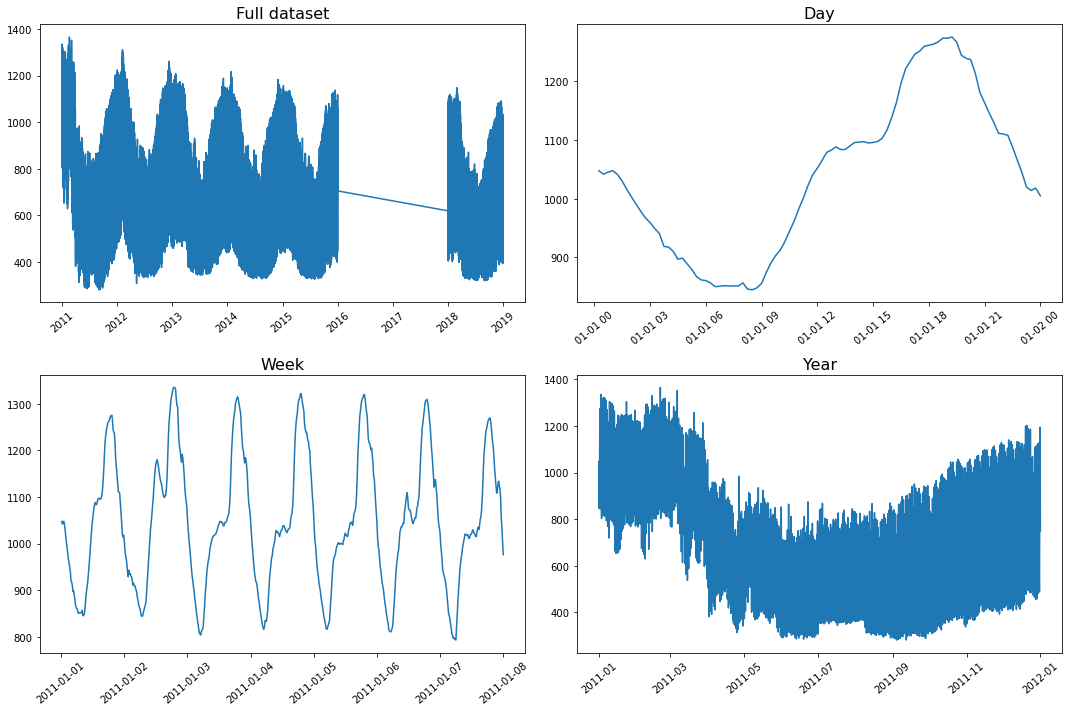

In [11]:
fig,axes = plt.subplots(2,2, figsize=(15,10))
limits = [len(df),96,672,35040]
titles = ["Full dataset", "Day", "Week", "Year"]

for i,ax in enumerate(axes.flat):
    ax.plot(dates[:limits[i]], df["mW"][:limits[i]])
    ax.set_title(titles[i], size=16)
    ax.tick_params(axis='x', labelrotation=40)

fig.tight_layout()

For our prediction we use the following factors:
1. sequentionality of data itself, by choosing to use a time series forecasting model with multi-step input
2. temperature and daytime as additional factors influencing the consumption

We compared the baseline performance of several neural network models in forecasting multiple timesteps of energy consumption based on a sequence of input timesteps of energy consumption, temperature and daytime.

We then took the best performing model type and conducted further experimentation on it to find the best performing hyperparameters.

Let us first look at each model with more detail.

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Models make predictions based on a window of consecutive samples from the time series.

Features of a window:
- width (number of input + output timesteps)
- time offset between input and output (predicting directly after the last timestep or with a shift)
- which features are used as inputs and labels

WindowGenerator class can:

- Handle the indexes and offsets
- Split windows of features into a (features, labels) pairs
- Plot the content of the resulting windows.
- Generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.


In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        """Split list of consecutive inputs into a window of inputs and window of (training) labels"""
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='mW', max_subplots=3):
        """Visualization of the split window"""
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                             label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                        marker='X', edgecolors='k', label='Predictions',
                                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        """Create batchable tf.data.Datasets for iteration over data"""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=True,
                batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [14]:
def create_window(dfs, input_timesteps, output_timesteps):
    """Create a window generator with multiple-timestep input and output """
    train_df = dfs[0]
    val_df = dfs[1]
    test_df = dfs[2]

    multistep_window = WindowGenerator(
        input_width=input_timesteps, # n of timestamps that are input for prediction
        label_width=output_timesteps, # how many to predict
        shift=output_timesteps,
        train_df=train_df, val_df=val_df, test_df=test_df)

    return multistep_window

In [15]:
def compile_model(multistep_model, lr):
    """Compile model with given learning rate"""

    multistep_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=[tf.metrics.MeanAbsoluteError()])

    return multistep_model

In [16]:
def fit_model(multistep_model, window, epochs=20):
    """Traint a model on the generator window during given number of epochs"""

    history = multistep_model.fit(window.train, epochs=epochs,
                          validation_data=window.val)

    return history

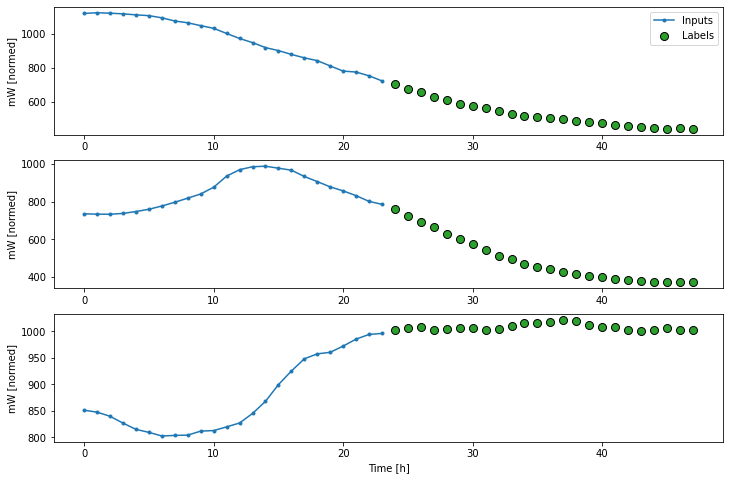

In [17]:
input_steps = 24
output_steps = 24
num_features = 1

multi_window = WindowGenerator(input_width=input_steps,
                               label_width=output_steps,
                               shift=output_steps,
                               label_columns=["mW"],
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df)

multi_window.plot()

In [46]:
# Define dictionaries for performance comparison
multi_val_performance = {}
multi_performance = {}

We will compare three types of models:
- Multilayer Dense (simple Feed Forward Neural Network)
- Convolutional Neural Network with several convolutions
- Long Short Term Memory Network

## 2.0. Baseline
First, setting a baseline for comparison with actual models performance.

Two models are used as baseline:
- repeating the last timestep for all predictions
- repeating the input timestep sequence as a prediction

1314/1314 [==============================] - 3s 2ms/step - loss: 327052.7188 - mean_absolute_error: 484.9252


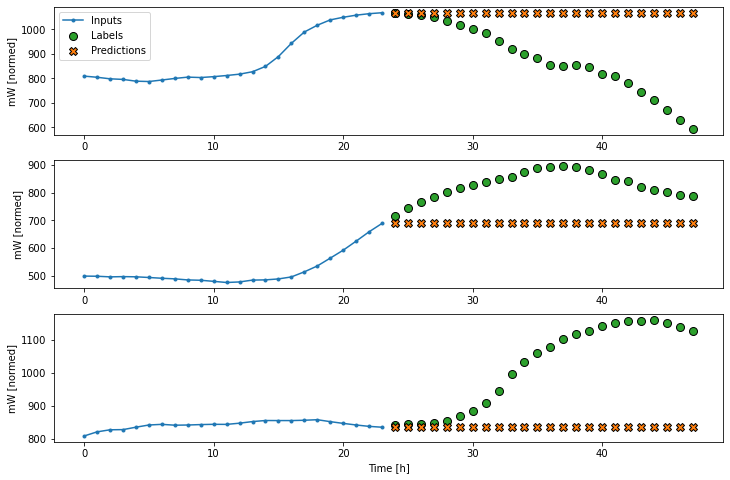

In [48]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, output_steps, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline_Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline_Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1314/1314 [==============================] - 3s 2ms/step - loss: 340701.4062 - mean_absolute_error: 513.9308


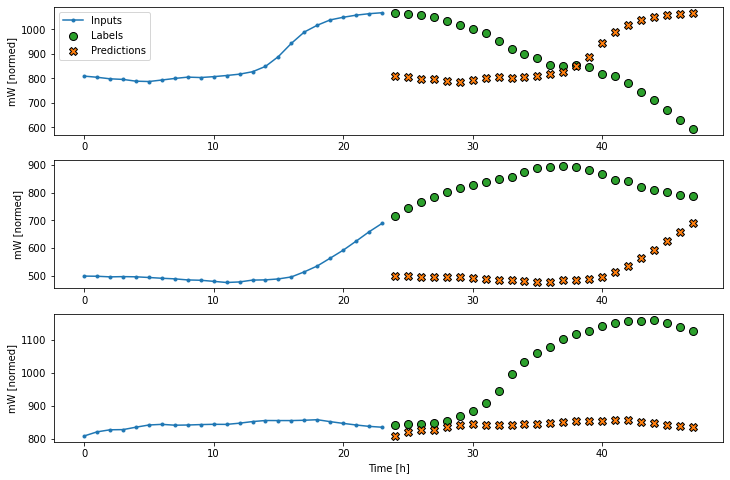

In [49]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline_Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Baseline_Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## 2.1. Multilayer dense


Predicts output timesteps from a single timestep (last in the input sequence) with a single dense inner layer model.
(This type of model is underpowered and only captures a low-dimensional slice of the behavior).

1314/1314 [==============================] - 3s 2ms/step - loss: 2035.3624 - mean_absolute_error: 32.7289


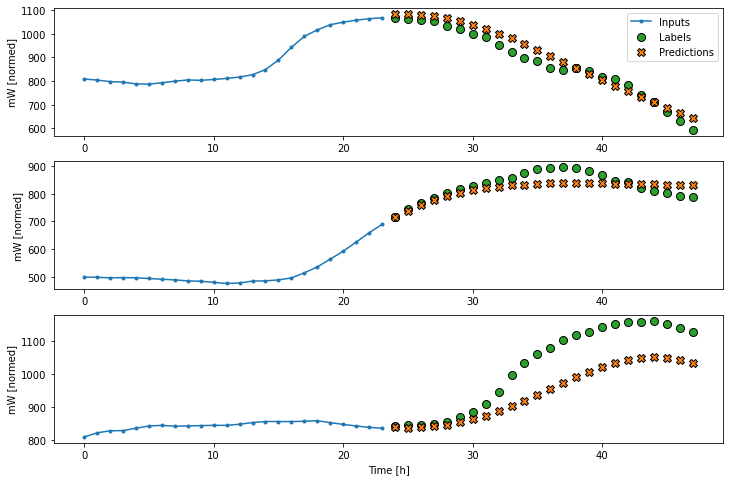

In [75]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([output_steps, num_features])
])

multi_dense_model = compile_model(multi_dense_model, lr=0.001)
history = fit_model(multi_dense_model, multi_window,20)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## 2.2. CNN with multiple convolutions
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time.

To capture the patterns in the data, I use three stacked convolutional layers with MaxPool layers inbetween, followed by two Dense layers for prediction.

1314/1314 [==============================] - 4s 3ms/step - loss: 1370.6779 - mean_absolute_error: 25.9363


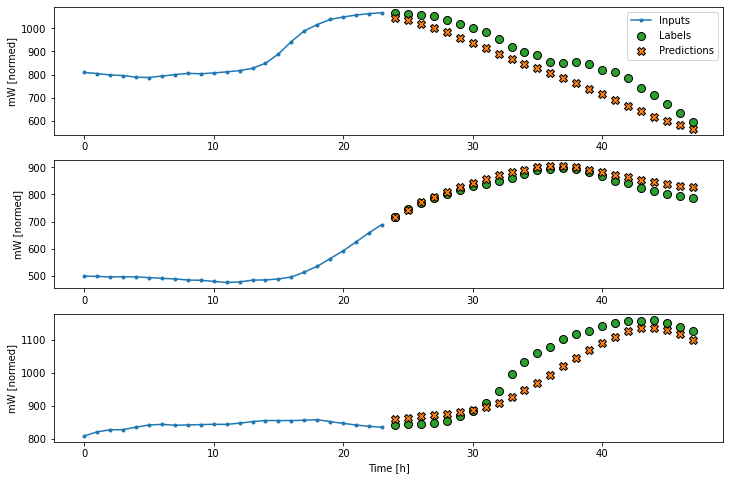

In [62]:
CONV_WIDTH = 24
num_features = 1

multi_conv_model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=256, kernel_size=(3), activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=256, kernel_size=(3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(output_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([output_steps, num_features])
])

multi_conv_model = compile_model(multi_conv_model, lr=0.001)
history = fit_model(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## 2.3. LSTM

A recurrent model can learn to use a long history of inputs, if it is relevant to predictions. It accumulates the state of the input time sequence before making a full prediction for the output sequence.

Here I use a layer with 512 LSTM units followed by a Dense layer.

1314/1314 [==============================] - 37s 28ms/step - loss: 1343.2423 - mean_absolute_error: 26.4239


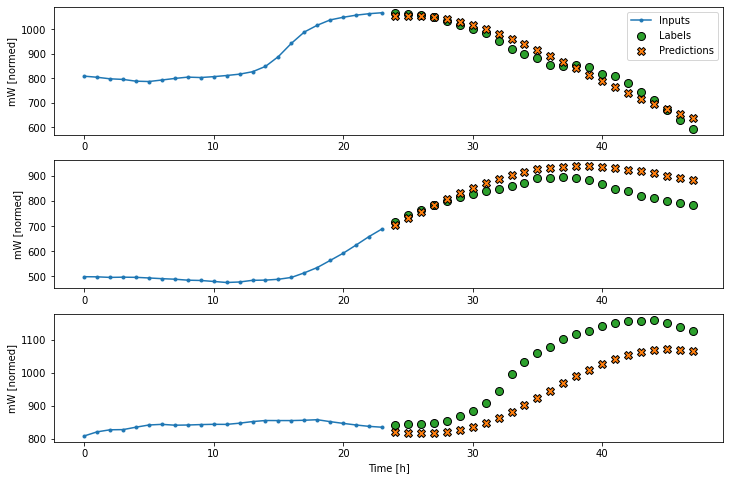

In [63]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, return_sequences=False),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([output_steps, num_features])
])

multi_lstm_model = compile_model(multi_lstm_model, lr=0.001)
history = fit_model(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Performance comparison

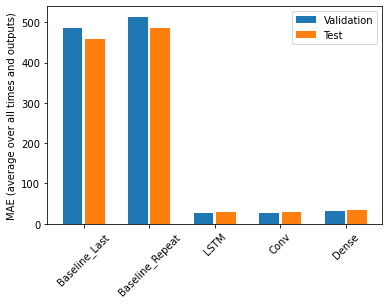

In [76]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_conv_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# 3. Grid search for best hyperparameters on the best model type

In [ ]:
import re

In [109]:
gridsearch_performance = {}

In [110]:
def train_test_model(window, params, epochs=10):
    LR = params["LR"]
    DENSE_UNITS = params["DENSE_UNITS"]
    
    
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(512, return_sequences=False),
        tf.keras.layers.Dense(DENSE_UNITS),
        tf.keras.layers.Dense(output_steps*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([output_steps, num_features])
    ])

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LR),
                metrics=[tf.metrics.MeanAbsoluteError()])

    model.fit(window.train, epochs=epochs,
                          validation_data=window.val)
    

    _, mae = model.evaluate(multi_window.test, verbose=0)

    return mae

In [111]:
LEARNING_RATES = [1e-3, 1e-4, 1e-5, 1e-6, 1e-10]
DENSE_UNITS = [100, 256]

In [ ]:
session_num = 0

for dense_units in DENSE_UNITS:  
    for lr in LEARNING_RATES:
        params = {
                "LR": lr,
                "DENSE_UNITS": dense_units
        }
        # redo this
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        session_name = f"lr_{lr}_dense_{dense_units}"
        print(session_name)
        mae = train_test_model(multi_window, params, epochs=10)
        gridsearch_performance[session_name] = mae
        
        session_num += 1

In [112]:
session_num = 0

for dense_units in DENSE_UNITS:  
    for lr in LEARNING_RATES:
        params = {
                "LR": lr,
                "DENSE_UNITS": dense_units
        }
        # redo this
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        session_name = f"lr_{lr}_dense_{dense_units}"
        print(session_name)
        mae = train_test_model(multi_window, params, epochs=10)
        gridsearch_performance[session_name] = mae
        
        session_num += 1

--- Starting trial: run-0
lr_0.001_dense_100
Epoch 1/10
4600/4600 [==============================] - 358s 78ms/step - loss: 19131.5117 - mean_absolute_error: 89.6897 - val_loss: 3089.5229 - val_mean_absolute_error: 41.5166
Epoch 2/10
4600/4600 [==============================] - 359s 78ms/step - loss: 3212.7122 - mean_absolute_error: 42.0756 - val_loss: 2481.0532 - val_mean_absolute_error: 37.3386
Epoch 3/10
4600/4600 [==============================] - 360s 78ms/step - loss: 2660.8936 - mean_absolute_error: 37.8335 - val_loss: 1850.1487 - val_mean_absolute_error: 31.5851
Epoch 4/10
4600/4600 [==============================] - 362s 79ms/step - loss: 2485.9609 - mean_absolute_error: 36.2973 - val_loss: 1892.2766 - val_mean_absolute_error: 31.8261
Epoch 5/10
4600/4600 [==============================] - 372s 81ms/step - loss: 2368.4270 - mean_absolute_error: 35.3407 - val_loss: 2231.7292 - val_mean_absolute_error: 34.9839
Epoch 6/10
4600/4600 [==============================] - 361s 78ms/ste

Epoch 10/10
4600/4600 [==============================] - 367s 80ms/step - loss: 248974.0938 - mean_absolute_error: 454.0645 - val_loss: 184956.4844 - val_mean_absolute_error: 387.1129
--- Starting trial: run-9
lr_1e-10_dense_256
Epoch 1/10
4600/4600 [==============================] - 368s 80ms/step - loss: 554848.3125 - mean_absolute_error: 715.8344 - val_loss: 490031.7188 - val_mean_absolute_error: 674.5069
Epoch 2/10
4600/4600 [==============================] - 367s 80ms/step - loss: 554848.1250 - mean_absolute_error: 715.8354 - val_loss: 490031.4375 - val_mean_absolute_error: 674.5070
Epoch 3/10
4600/4600 [==============================] - 368s 80ms/step - loss: 554847.7500 - mean_absolute_error: 715.8349 - val_loss: 490031.6562 - val_mean_absolute_error: 674.5071
Epoch 4/10
4600/4600 [==============================] - 367s 80ms/step - loss: 554847.5000 - mean_absolute_error: 715.8342 - val_loss: 490031.6250 - val_mean_absolute_error: 674.5074
Epoch 5/10
4600/4600 [=================

In [113]:
gridsearch_performance

{'lr_0.001_dense_100': 30.289310455322266,
 'lr_0.0001_dense_100': 26.845367431640625,
 'lr_1e-05_dense_100': 67.11715698242188,
 'lr_1e-06_dense_100': 526.0383911132812,
 'lr_1e-10_dense_100': 640.2051391601562,
 'lr_0.001_dense_256': 35.28562545776367,
 'lr_0.0001_dense_256': 27.672861099243164,
 'lr_1e-05_dense_256': 36.73331832885742,
 'lr_1e-06_dense_256': 352.7760925292969,
 'lr_1e-10_dense_256': 640.2050170898438}

Text(0, 0.5, 'MAE (average over all times and outputs)')

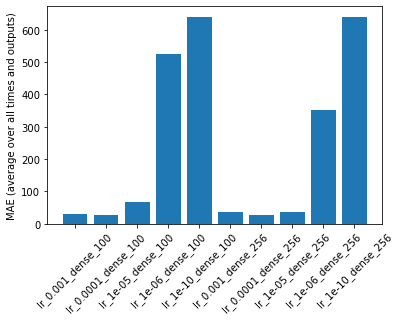

In [114]:
plt.bar(*zip(*gridsearch_performance.items()))
plt.xticks(rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')

# Train best combination of params for a longer amount of epochs to get the final model

In [75]:
best_params = min(gridsearch_performance, key=gridsearch_performance.get)
best_lr = float(re.search("(?<=lr_)(.*?)(?=_)", best_params)[0])
best_dense_units = int(re.search("[^|dense_]*$", best_params)[0])

In [78]:
best_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, return_sequences=False),
    tf.keras.layers.Dense(best_dense_units),
    tf.keras.layers.Dense(output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([output_steps, num_features])
])

best_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(learning_rate=best_lr),
            metrics=[tf.metrics.MeanAbsoluteError()])

best_model.fit(multi_window.train, epochs=35,
                      validation_data=multi_window.val)

IPython.display.clear_output()

In [79]:
best_model.evaluate(multi_window.test, verbose=0)

[1675.600341796875, 26.683202743530273]

Saving the model in Tensorflow SavedModel format for later use in the prediction application.

In [81]:
best_model.save('model')